<a href="https://colab.research.google.com/github/FrancoiseQ/TM10007_ML_Project/blob/test_brach_francoise/Machine_Learning_group_8_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from scipy.stats import uniform
from sklearn import metrics, model_selection, preprocessing, svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import LinearSVC

# Loading data zip file

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


# Preprocessing data

Below the data is preprocessed, firstly splitting the data into a training, validation and test set. Then the data is scaled, upsampled and PCA is applied. The datasets are defined for their respective classifiers.

In [ ]:
def load_data():
    this_directory = os.path.dirname(os.path.abspath(_file_))
    data = pd.read_csv(os.path.join(this_directory, 'ecg_data.csv'), index_col=0)
    data = pd.DataFrame(data)
    return data

def extract_data(input_data):
    # Create variable Y
    Y = input_data['label']

    # Create variable X
    X = input_data.drop('label', axis=1)
    return X, Y

## Preparing data
# Load and extract data
X,y  = extract_data(data)

# Split the dataset in train and test part
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2,  random_state=42)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# Fit the StandardScaler on the training data
scaler = RobustScaler()
scaler.fit(X_train)

# Transform the upsampled training data, validation data and test data on the same scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Upsample minority class for NN and RF
oversample = SMOTE(random_state=42)
X_train_upsampled , y_train_upsampled = oversample.fit_resample(X_train, y_train)

# Upsample minority class in scaled data for SVM
X_train_upsampled_scaled , y_train_upsampled_scaled = oversample.fit_resample(X_train_scaled, y_train)

# Fit PCA on trainingsdata
pca = PCA(n_components=100)
pca.fit(X_train_upsampled_scaled)

# Transform validation data and test data
X_train_pca = pca.transform(X_train_upsampled_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Neural Network (NN) hyperparameter tuning

In this section, a neural network, MLPClassifier is fit to the training data. A randomized search is performed to find the optimal parameters. the upsampled datasets are used to reduce the effects of class imbalance.

In [ ]:
# Define hyperparameters distributions for RandomizedSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate_init': uniform(0.0001, 0.01)

}

# Initialize MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=400)

# Perform randomized search with StratifiedKFold Cross-validation on X_train_upsampled
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=StratifiedKFold(), random_state=42, scoring='recall')
random_search.fit(X_train_upsampled, y_train_upsampled)

# Display best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)

# Define MLP classifier with best parameters
best_mlp = MLPClassifier(**random_search.best_params_)



Best Hyperparameters:
{'activation': 'relu', 'alpha': 0.0016601864044243652, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.0010997491581800289, 'solver': 'adam'}


# Support Vector Machine (SVM) hyperparameter tuning

In this section, a SVM classifier is fit to the training dat. L1 regulization is used with different regulization parameters. A randomized search is performed using stratified K fold cross validation and recall as scoring metric.

In [ ]:
# Initialize SVM with L1 regularization
svm_l1 = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=300000) # Increased the number of iterations to convergence to a solution

# Define hyperparameter distribution
param_dist = {'C': uniform(0.00001, 10 - 0.00001)}  # Define a continuous distribution for C from 0.00001 (heavy regulization) to 10 (less regulization)

# Perform randomized search with StratifiedKFold Cross-validation on X_train
random_search = RandomizedSearchCV(svm_l1, param_distributions=param_dist, cv=StratifiedKFold(), random_state=42, scoring='recall')
random_search.fit(X_train_pca, y_train_upsampled)

# Retrieve the best model
best_svm_l1 = random_search.best_estimator_

# Display best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)


Best Hyperparameters:
{'C': 0.5808455408458729}


# Random Forest (RF) hyperparameter tuning
This code trains a random forest classifier and tunes the hyperparameters. Running this part of the code takes about 20 min

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=42)

# Define hyperparameters distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform RandomizedSearchCV on the training set for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=StratifiedKFold(), random_state=42, scoring='recall')
random_search.fit(X_train, y_train)

# Retrieve best estimator
best_rf_classifier = random_search.best_estimator_

# Display best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)


Best Hyperparameters:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}


# Learning curves

Compute separate learning curves for all fitted models to evaluate overfitting.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

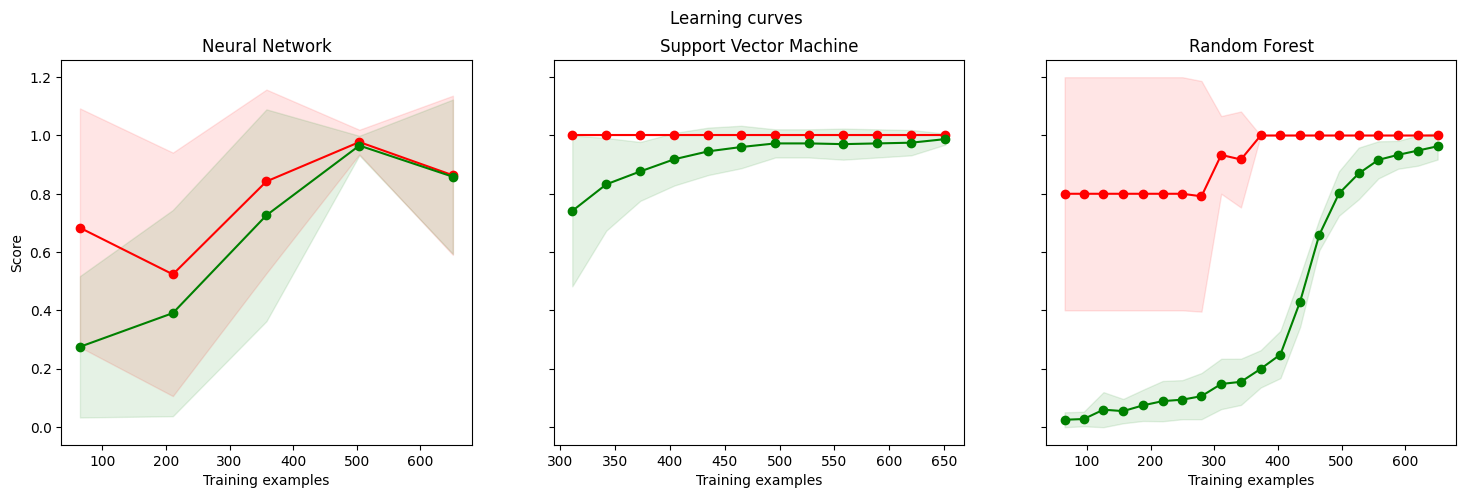

In [ ]:
# Create subplot for learning curves
fig, axs = plt.subplots(1,3, figsize=(18, 5), sharey=True)
fig.suptitle('Learning curves')

# Add neural network to first plot
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train_upsampled, y_train_upsampled, cv=StratifiedKFold(), n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
axs[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
axs[0].fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
axs[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
axs[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
axs[0].set_title('Neural Network')

# Add SVM to second plot
train_sizes, train_scores, test_scores = learning_curve(best_svm_l1, X_train_pca, y_train_upsampled, cv=StratifiedKFold(), scoring='recall', train_sizes=np.linspace(0.1, 1.0, 20))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

axs[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
axs[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
axs[1].plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
axs[1].plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
axs[1].set_title('Support Vector Machine')

# Add random forest to third plot
train_sizes, train_scores, test_scores = learning_curve(best_rf_classifier, X_train_upsampled , y_train_upsampled, cv=StratifiedKFold(), scoring='recall', train_sizes=np.linspace(0.1, 1.0, 20))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

axs[2].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
axs[2].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
axs[2].plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
axs[2].plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
axs[2].set_title('Random Forest')

for ax in axs.flat:
    ax.set(xlabel='Training examples', ylabel='Score')
    ax.label_outer()


# Precision recall curves

Compute precision recall curves for the three fitted models and add the curves to one plot. Calculate AUC to evaluate performance.

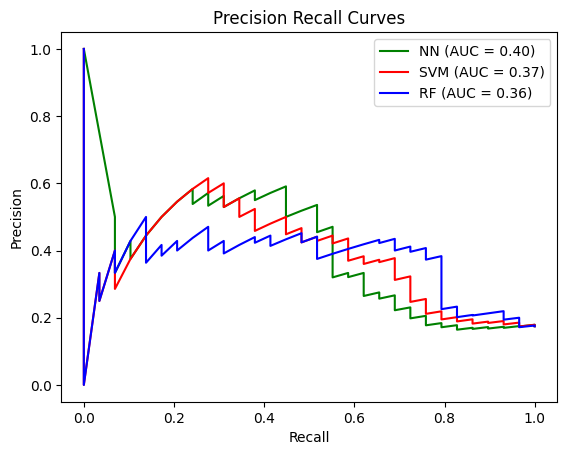

In [ ]:
# Plot specifications
fig, ax = plt.subplots()
ax.set_title('Precision Recall Curves')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# Add Neural Network
best_mlp = mlp.fit(X_train_upsampled, y_train_upsampled)
precision, recall, _ = precision_recall_curve(y_val, best_mlp.predict_proba(X_val)[:, 1])
ax.plot(recall, precision, color='green', label='NN (AUC = %0.2f)' % auc(recall, precision))

# Add SVM
precision, recall, _ = precision_recall_curve(y_val, best_svm_l1.decision_function(X_val_pca))
ax.plot(recall, precision, color='red', label='SVM (AUC = %0.2f)' % auc(recall, precision))

# Add RF
precision, recall, thresholds = precision_recall_curve(y_val, best_rf_classifier.predict_proba(X_val)[:, 1])
ax.plot(recall, precision, color='blue', label='RF (AUC = %0.2f)' % auc(recall, precision))

# Show plot
ax.legend(loc='upper right')
plt.show()


# Test on test data

Test the chosen model on the test data and calculate accuracy and recall.

In [ ]:
# Predictions on test data using neural network
y_pred = best_mlp.predict(X_test)

# Compute accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)

Accuracy: 0.7891566265060241
Recall: 0.4827586206896552
